<a href="https://colab.research.google.com/github/MartinaWestrik/Eurosat-Neural-Networks/blob/EuroSAT_vlastni_model/Eurosat_Neural_Networks_V0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INFO O PROJEKTU
**Cílem** projektu je vytrénování modelu, který na základě analýzy datasetu 27000 satelitních snímků ze zařízení Sentinel2 rozpoznává 10 druhů tříd land use - využití půdy, např. pole, pastvina, dálnice, jezera, řeky, zastavěné území, průmyslová zóna apod. Snímky mají po úpravě ze 13 spektrálního nastavení (EuroSATallBands, *tif) pouze tříbarvené kanály (RGB), rozměry 64x64 pixelů (EuroSAT, *.jpg) Projekt jsme si vybrali na https://www.kaggle.com/datasets/apollo2506/eurosat-dataset, k sestavování modelu jsme využili zdejší kody, chatgpt, vzorový příklad na Colab - šachy.

**Postup**

Postavení vlastního modelu neuronové sítě a ladění parametrů (V0)

Použití předtrénovaného modelu VGG16 (V1) a XXX (V2) pro efektivnější trénování.

Vyhodnocení modelů pomocí přesnosti a konfuzní matice.


# NAČÍTÁNÍ KNIHOVEN

In [95]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

import random
import numpy as np                                                   #knihovna pro práci s maticovými daty
import pandas as pd                                                  #knihovna pro práci s tabulkovými daty
import os

import matplotlib.pyplot as plt                                      #knihovna na vizualizaci                                                            #knihovna pro práci s adresáři
from PIL import Image                                                #modul PythonImagineLibrary je součástí knihovny Pillow otevírání, úpravy a ukládání obrázků v různých formátech (JPEG, PNG, BMP, GIF atd.).

from tensorflow.keras.preprocessing.image import ImageDataGenerator  #nástroj pro augmentaci - dávkuje načítání, generuje nové obrázky, normalizuje obrázky)
from tensorflow.keras.callbacks import EarlyStopping                 #mechanismus bránící přeučení tím, že se zastaví, když se přestane model zlepšovat ve vybraných parametrech
from tensorflow.keras.callbacks import ModelCheckpoint               #ukládá nejlepší verzi modelu, nejlepší váhy, při přerušení lze načíst poslední verzi a pokračovat z posledního checkpointu
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# NAČTENÍ DAT


In [96]:
# Stažení aktuální verze dat z Kaggle
path_to_download = kagglehub.dataset_download("apollo2506/eurosat-dataset")
print("Obsah datasetu:")
print(os.listdir(path_to_download))

Obsah datasetu:
['EuroSATallBands', 'EuroSAT']


In [97]:
# Vyhledání všech CSV souborů
csv_files = []
for root, dirs, files in os.walk(path_to_download):
    for file in files:
        if file.endswith(".csv"):
            csv_files.append(os.path.join(root, file))

# Výpis nalezených CSV souborů
print("Nalezené CSV soubory:\n")
for csv in csv_files:
    print(csv)

Nalezené CSV soubory:

/root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6/EuroSATallBands/test.csv
/root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6/EuroSATallBands/train.csv
/root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6/EuroSATallBands/validation.csv
/root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6/EuroSAT/test.csv
/root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6/EuroSAT/train.csv
/root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6/EuroSAT/validation.csv


In [98]:
# Načtení CSV souborů = landuse labelů -  do tabulek
train_df = pd.read_csv(os.path.join(path_to_download, "EuroSAT/train.csv"))
val_df = pd.read_csv(os.path.join(path_to_download, "EuroSAT/validation.csv"))
test_df = pd.read_csv(os.path.join(path_to_download, "EuroSAT/test.csv"))

In [99]:
# Přidání úplné cesty k obrázkům
train_df["Filename"] = train_df["Filename"].apply(lambda x: os.path.join(path_to_download,"EuroSAT", x))
val_df["Filename"] = val_df["Filename"].apply(lambda x: os.path.join(path_to_download,"EuroSAT", x))
test_df["Filename"] = test_df["Filename"].apply(lambda x: os.path.join(path_to_download,"EuroSAT", x))


In [100]:
# Zobrazení prvních 5 řádků jako tabulky
print("Trénovací sada:")
display(train_df.head())  # Funguje jen v Jupyter Notebooku

print("\n Validační sada:")
display(val_df.head())

print("\n Testovací sada:")
display(test_df.head())

Trénovací sada:


,Unnamed: 0,Filename,Label,ClassName
0,16257,/root/.cache/kagglehub/datasets/apollo2506/eur...,0,AnnualCrop
1,3297,/root/.cache/kagglehub/datasets/apollo2506/eur...,2,HerbaceousVegetation
2,17881,/root/.cache/kagglehub/datasets/apollo2506/eur...,6,PermanentCrop
3,2223,/root/.cache/kagglehub/datasets/apollo2506/eur...,4,Industrial
4,4887,/root/.cache/kagglehub/datasets/apollo2506/eur...,2,HerbaceousVegetation



 Validační sada:


,Unnamed: 0,Filename,Label,ClassName
0,258,/root/.cache/kagglehub/datasets/apollo2506/eur...,5,Pasture
1,2134,/root/.cache/kagglehub/datasets/apollo2506/eur...,1,Forest
2,3518,/root/.cache/kagglehub/datasets/apollo2506/eur...,3,Highway
3,3048,/root/.cache/kagglehub/datasets/apollo2506/eur...,8,River
4,3996,/root/.cache/kagglehub/datasets/apollo2506/eur...,9,SeaLake



 Testovací sada:


,Unnamed: 0,Filename,Label,ClassName
0,2438,/root/.cache/kagglehub/datasets/apollo2506/eur...,0,AnnualCrop
1,1018,/root/.cache/kagglehub/datasets/apollo2506/eur...,7,Residential
2,3,/root/.cache/kagglehub/datasets/apollo2506/eur...,5,Pasture
3,1011,/root/.cache/kagglehub/datasets/apollo2506/eur...,7,Residential
4,47,/root/.cache/kagglehub/datasets/apollo2506/eur...,5,Pasture


In [101]:
# Vytvoření slovníku pro převod Label -> ClassName
label_to_class = train_df[["Label", "ClassName"]].drop_duplicates().set_index("Label")["ClassName"].to_dict()

# Výpis přiřazení
print("Přiřazení kategorií landuse:\n")
for label, class_name in sorted(label_to_class.items()):
    print(f"{label}: {class_name}")

Přiřazení kategorií landuse:

0: AnnualCrop
1: Forest
2: HerbaceousVegetation
3: Highway
4: Industrial
5: Pasture
6: PermanentCrop
7: Residential
8: River
9: SeaLake


# DATA - ANALÝZA A PREPROCESING

#Zjišťujeme,

1.   jaké mají fotky rozměry,
2.   vizuálně hodnotíme, jak fotky vypadají pro člověka a jak jsou barevně ne/pestré
3.   normalizace pixelových hodnot (škálování do rozmezí 0–1) a augmentace
4.   změna rozměrů obrázků - není třeba, když si stavíme model
5.   one-hot encoding labelů (převod kategorií na numerické vektory)
6.   kontrola dat v trénovací, validační a testovací sadě


### Ověření rozměrů fotek

In [102]:
sample_img_path = None
for root, _, files in os.walk(path_to_download):
    for file in files:
        if file.endswith((".jpg", ".png")):  # Zkontrolujeme, zda je to obrázek
            sample_img_path = os.path.join(root, file)
            break
    if sample_img_path:
        break

# Načtení a zjištění rozměrů
if sample_img_path:
    img = Image.open(sample_img_path)
    print(f"Náhodný RGB obrázek: {sample_img_path}")
    print(f"Rozlišení: {img.size}")  # (šířka, výška)
    print(f"Počet kanálů: {len(img.getbands())}")  # Očekáváme 3 (RGB)
else:
    print("❌ Nenašel jsem žádné RGB obrázky v datasetu!")

Náhodný RGB obrázek: /root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6/EuroSAT/River/River_473.jpg
Rozlišení: (64, 64)
Počet kanálů: 3


### Vizuální zhodnocení kvality fotek = stačí rozlišení na tréning?

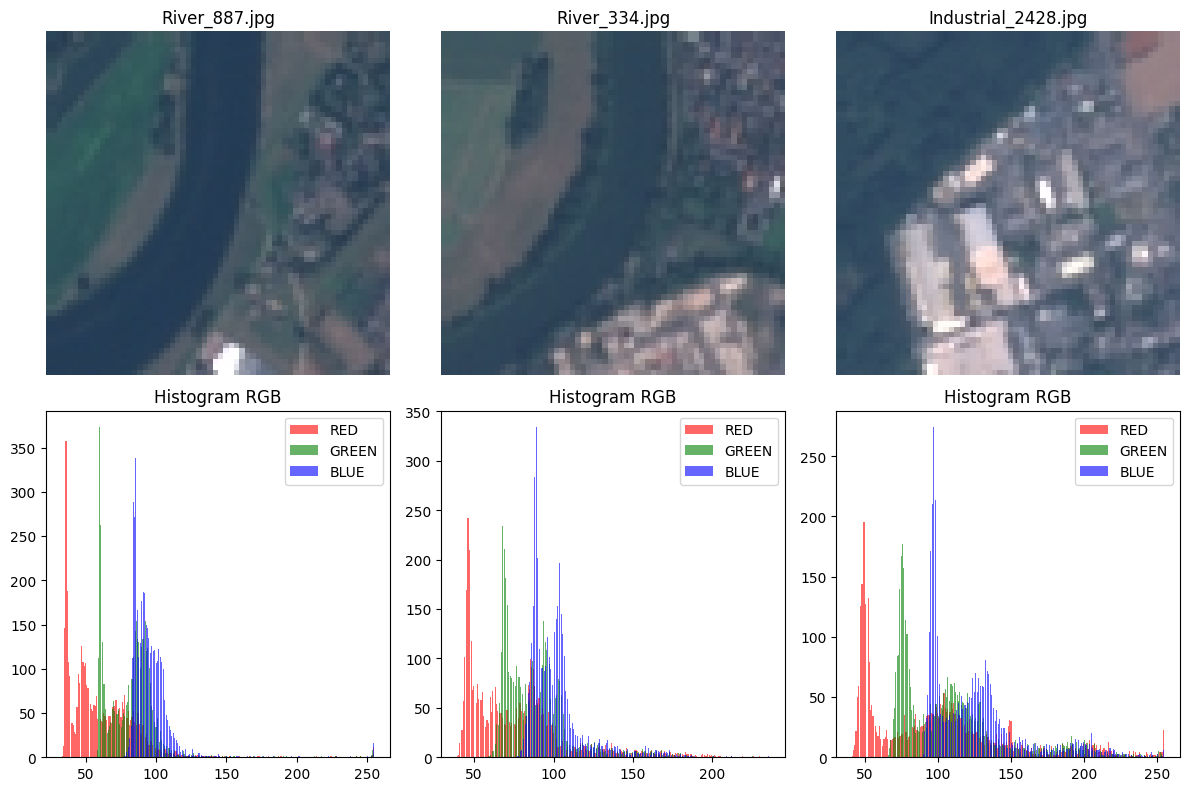

In [103]:
# Výběr 3 náhodných obrázků
all_images = []
for root, _, files in os.walk(path_to_download):
    all_images.extend([os.path.join(root, file) for file in files if file.endswith((".jpg", ".png"))])
random_images = random.sample(all_images, 3)

# Vykreslení obrázků a jejich histogramů
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2 řádky, 3 sloupce (obrázky nahoře, histogramy dole)

for i, img_path in enumerate(random_images):
    img = Image.open(img_path)
    img_array = np.array(img)  # Převod na NumPy pole

    # Vykreslení obrázku (horní řádek)
    axes[0, i].imshow(img)
    axes[0, i].set_title(os.path.basename(img_path))
    axes[0, i].axis("off")

    # Vykreslení histogramu RGB (dolní řádek)
    colors = ["red", "green", "blue"]
    for j, color in enumerate(colors):
        axes[1, i].hist(img_array[:, :, j].ravel(), bins=256, color=color, alpha=0.6, label=color.upper())

    axes[1, i].set_title("Histogram RGB")
    axes[1, i].legend()

plt.tight_layout()
plt.show()


###Normalizace sad a augmentace trénovací sady


In [104]:
# Trénovací data znormalizujeme a aplikujeme na ni augmentaci:
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # normalizace pixelů (0–1)
    rotation_range=30,              # náhodná rotace
    width_shift_range=0.2,          # norizontální posun
    height_shift_range=0.2,         # nertikální posun
    zoom_range=0.2,                 # náhodné přiblížení
    horizontal_flip=False,          # zrcadlení jsem zakázala, protože stíny, směr sever apod...
    fill_mode="nearest"             #vyplní případně prázdné pixely barvou nejbližších okolních
)

val_datagen = ImageDataGenerator(
    rescale=1./255
    ) # Pouze normalizace, bez augmentace

### Převedení na stupně šedi a pak terpve normalizace - ZATÍM NEAPLIKOVÁNO

# Funkce pro převod na grayscale a normalizaci
def convert_to_grayscale_and_normalize(image_path):
    img = Image.open(image_path).convert("L")  # 1️⃣ Převod na grayscale
    img_array = np.array(img, dtype=np.float32) / 255.0  # 2️⃣ Normalizace do 0–1
    return img, img_array  # Vrátíme původní grayscale obrázek i NumPy array

# Vykreslení obrázků před a po převodu
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2 řádky, 3 sloupce

for i, img_path in enumerate(random_images):
    # Načtení původního obrázku (RGB)
    img_original = Image.open(img_path)

    # Převod na grayscale + normalizace
    img_gray, img_gray_array = convert_to_grayscale_and_normalize(img_path)

    # Vykreslení původního obrázku (horní řádek)
    axes[0, i].imshow(img_original)
    axes[0, i].set_title(f"Původní: {os.path.basename(img_path)}")
    axes[0, i].axis("off")

    # Vykreslení grayscale obrázku (dolní řádek)
    axes[1, i].imshow(img_gray_array, cmap="gray")
    axes[1, i].set_title("Grayscale + normalizace")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

###Rozložení landuse kategorií v sadě trénovací/validační/testovací


In [105]:
def count_labels(df, dataset_name):
    label_counts = df["ClassName"].value_counts()  # Spočítání obrázků pro každou třídu
    print(f" Počet obrázků ve {dataset_name} sadě:\n")
    for label, count in label_counts.items():
        print(f"{label}: {count} obrázků")
    print("-" * 40)

# Spočítání pro všechny datasetové sady
count_labels(train_df, "trénovací")
count_labels(val_df, "validační")
count_labels(test_df, "testovací")

 Počet obrázků ve trénovací sadě:

AnnualCrop: 2100 obrázků
HerbaceousVegetation: 2100 obrázků
SeaLake: 2100 obrázků
Forest: 2100 obrázků
Residential: 2100 obrázků
PermanentCrop: 1750 obrázků
Industrial: 1750 obrázků
Highway: 1750 obrázků
River: 1750 obrázků
Pasture: 1400 obrázků
----------------------------------------
 Počet obrázků ve validační sadě:

Forest: 600 obrázků
AnnualCrop: 600 obrázků
HerbaceousVegetation: 600 obrázků
SeaLake: 600 obrázků
Residential: 600 obrázků
Highway: 500 obrázků
PermanentCrop: 500 obrázků
River: 500 obrázků
Industrial: 500 obrázků
Pasture: 400 obrázků
----------------------------------------
 Počet obrázků ve testovací sadě:

AnnualCrop: 300 obrázků
Residential: 300 obrázků
HerbaceousVegetation: 300 obrázků
SeaLake: 300 obrázků
Forest: 300 obrázků
PermanentCrop: 250 obrázků
Highway: 250 obrázků
River: 250 obrázků
Industrial: 250 obrázků
Pasture: 200 obrázků
----------------------------------------


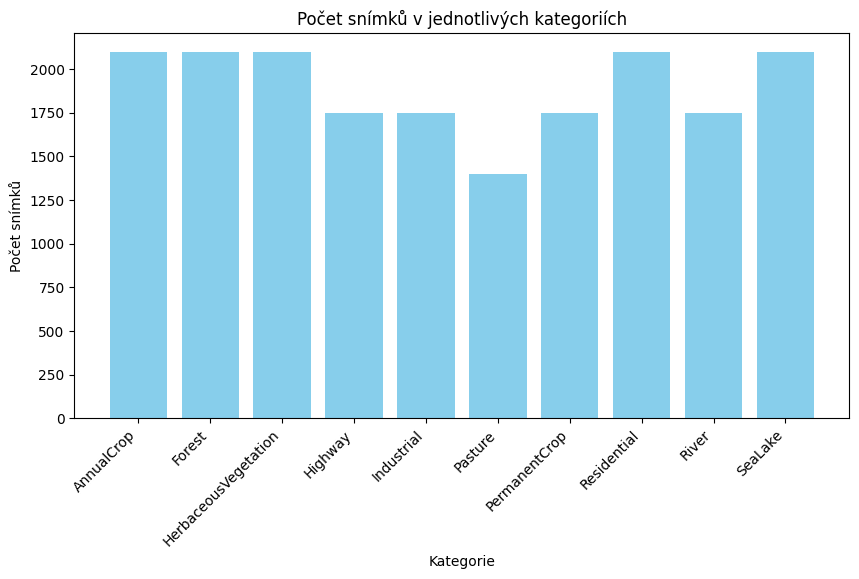

In [106]:
#Kolik je v každém labelu v trénovací sadě snímků?
label_counts = train_df["Label"].value_counts().sort_index()

# Vytvoření DataFrame
df_counts = pd.DataFrame({
    "Label": label_counts.index,
    "ClassName": [label_to_class[label] for label in label_counts.index],
    "Počet snímků": label_counts.values
})

# Vykreslení sloupcového grafu
plt.figure(figsize=(10, 5))
plt.bar(df_counts["ClassName"], df_counts["Počet snímků"], color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Kategorie")
plt.ylabel("Počet snímků")
plt.title("Počet snímků v jednotlivých kategoriích")
plt.show()

In [107]:

# Generátory dat
train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col="Filename", y_col="ClassName", target_size=(64,64), batch_size=32, class_mode="categorical"
)
val_generator = val_datagen.flow_from_dataframe(
    val_df, x_col="Filename", y_col="ClassName", target_size=(64,64), batch_size=32, class_mode="categorical"
)

Found 18900 validated image filenames belonging to 10 classes.
Found 5400 validated image filenames belonging to 10 classes.


# DEFINICE MODELU

Je třeba napojit znormalizovaná data na model tak, aby se neukládala, ale upravovala se při vstupu do modelu.

##### **Připojení dat k generatoru (příklad se složkami datasetu)**
train_generator = datagen.flow_from_directory(
    "cesta_k_trenovacimu_datasetu",
    target_size=(64, 64),
    batch_size=32,
    class_mode="categorical"  # Používáme, pokud máme více tříd
)

Sequential - callback = early stopping, ukládání nejlepšího modelu kvůli kapacitě colabu => psát si výsledky + checkpoints

##Přednastavení


###Early Stopping


In [108]:
#nastavuji při vědomí, že se může val_accuracy ještě zlepšovat - rozpoznávání tříd
early_stopping = EarlyStopping(
    monitor="val_loss",      # sledujeme validační ztrátu
    patience=5,              # Po kolika epochách bez zlepšení zastavit trénování
    min_delta=0.05,
    restore_best_weights=True # Po zastavení vrátí nejlepší váhy modelu
)

###Model Checkpoint


In [109]:
#ukládání nejlepšího modelu;
model_checkpoint = ModelCheckpoint(
    "best_model.h5",       # název souboru pro uložení modelu
    monitor="val_loss",    # sledujeme validační ztrátu (nižší = lepší model)
    save_best_only=True,   # uloží pouze nejlepší model
    mode="min",            # protože chceme minimalizovat `val_loss`
    verbose=1              # výpis informací při ukládání
)

###ReduceLROnPlateau

In [110]:
#dynamické snižovnání rychlosti učení, brání zaseknutí v lokálním minimu, snižuje validační ztrátu = čím nižší, tím lepší model
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",   # sleduje val_loss
    factor=0.5,           # sníží learning rate na polovinu
    patience=3,           # ..po 3 epochách bez zlepšení
    min_lr=1e-6,          # minimální možná hodnota learning rate
    verbose=1             # výpíše informace při změně
)

## Postavení modelu


In [111]:
# vytvoření  vlastního modelu, ; Sequentional= každá vrstva přidává novou transformaci dat, která zlepšuje schopnost modelu rozpoznávat vzory
model = Sequential([
    # první konvoluční vrstva
    Input(shape=(64, 64, 3)),
    Conv2D(32, (3,3), activation='relu'), #32 filtrů hledá jiné vzory v matrici 3x3 pixely, "relu"převádí záporné hodnoty aktivační funkce na nulu, model očekává obrázky RGB 64x64
    MaxPooling2D(2,2),                                             # pooling snižuje velikost obrázků (na polovinu = 32x32) => snižuje rozsah výpočtu a vybírá ty nejdůležitější tvary na obrázku

    # druhá konvoluční vrstva
    Conv2D(64, (3,3), activation='relu'),                           #64 filtrů analyzuje složitější tvary, rysy na obrázku
    MaxPooling2D(2,2),                                              # snižuje velikost obrázku na 16x16

    # třetí konvoluční vrstva
    Conv2D(128, (3,3), activation='relu'),                          #nasazuje 128 filtrů
    MaxPooling2D(2,2),                                               #snižuje velikost obrázku na 8x8

    # zploštění převede data z 8x8x128 => máme vektor s 8 192 prvky, které mohou vstoupit do dense vsrtvy se 128 neurony  a
    Flatten(),

    # .... do dense vsrtvy se 128 neurony a přirpavit se na klasifikaci
    Dense(128, activation='relu'),
    Dropout(0.5),                                                   # v dense vrstvě "vypne" 50% neuronů, brání tím přeučení

    # výstupní vrstva s 10 třídami (softmax pro klasifikaci)
    Dense(10, activation='softmax')
])

###Optimizační algoritmus a ztrátová funkce

In [112]:
model.compile(
    optimizer="adam",                #  optimalizuje váhy a optimalizační algoritmus; modelu říkám, že se má učit podle gradientu
    loss="categorical_crossentropy",  # vyhodnocení chyby a snaha o její znižování
    metrics=["accuracy"]              # nastavuje přesnost, abychom viděli výkon modelu
)

###Batch size

In [115]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    batch_size=32,  # Nastavení batch size
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)



Epoch 1/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8390 - loss: 0.4717
Epoch 1: val_loss did not improve from 0.33839
591/591 ━━━━━━━━━━━━━━━━━━━━ 34s 57ms/step - accuracy: 0.8390 - loss: 0.4717 - val_accuracy: 0.8835 - val_loss: 0.3774 - learning_rate: 0.0010
Epoch 2/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8482 - loss: 0.4463
Epoch 2: val_loss did not improve from 0.33839
591/591 ━━━━━━━━━━━━━━━━━━━━ 33s 56ms/step - accuracy: 0.8483 - loss: 0.4462 - val_accuracy: 0.8448 - val_loss: 0.4896 - learning_rate: 0.0010
Epoch 3/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8511 - loss: 0.4348
Epoch 3: val_loss did not improve from 0.33839
591/591 ━━━━━━━━━━━━━━━━━━━━ 33s 56ms/step - accuracy: 0.8511 - loss: 0.4348 - val_accuracy: 0.8733 - val_loss: 0.3838 - learning_rate: 0.0010
Epoch 4/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8577 - loss: 0.4221
Epoch 4: val_loss did not improve from 0.33839
591/591 ━━━━━━━━━━━━━━━━━━━━ 42s 58

591/591 ━━━━━━━━━━━━━━━━━━━━ 34s 58ms/step - accuracy: 0.8629 - loss: 0.4121 - val_accuracy: 0.8941 - val_loss: 0.3102 - learning_rate: 0.0010
Epoch 7/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8658 - loss: 0.3997
Epoch 7: val_loss improved from 0.31022 to 0.30104, saving model to best_model.h5


591/591 ━━━━━━━━━━━━━━━━━━━━ 33s 55ms/step - accuracy: 0.8658 - loss: 0.3997 - val_accuracy: 0.8989 - val_loss: 0.3010 - learning_rate: 0.0010
Epoch 8/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8759 - loss: 0.3765
Epoch 8: val_loss improved from 0.30104 to 0.24051, saving model to best_model.h5


591/591 ━━━━━━━━━━━━━━━━━━━━ 34s 57ms/step - accuracy: 0.8759 - loss: 0.3765 - val_accuracy: 0.9172 - val_loss: 0.2405 - learning_rate: 0.0010
Epoch 9/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8811 - loss: 0.3537
Epoch 9: val_loss did not improve from 0.24051
591/591 ━━━━━━━━━━━━━━━━━━━━ 34s 57ms/step - accuracy: 0.8811 - loss: 0.3537 - val_accuracy: 0.8328 - val_loss: 0.5456 - learning_rate: 0.0010
Epoch 10/50
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8764 - loss: 0.3615
Epoch 10: val_loss did not improve from 0.24051
591/591 ━━━━━━━━━━━━━━━━━━━━ 33s 55ms/step - accuracy: 0.8764 - loss: 0.3615 - val_accuracy: 0.9065 - val_loss: 0.2689 - learning_rate: 0.0010
Epoch 11/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8855 - loss: 0.3492
Epoch 11: val_loss did not improve from 0.24051

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
591/591 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - accuracy: 0.8855 - loss: 0.3492 - val_accu

# TRÉNOVÁNÍ MODELU


#Ukládání modelu


# Vyhodnocení modelu



# Analýza chyb



# Shrnutí výsledků


# Závěr
Shrnutí celého procesu: od přípravy datasetu po analýzu výsledků.
Možnosti aplikace modelu v praxi (např. monitoring změn krajiny, urbanizace).
Doporučení pro budoucí vylepšení modelu.